In [1]:
import itertools
import random as rand

import math
import matplotlib.pyplot as plt
import numpy as np

from IPython.display import clear_output
import copy

In [2]:
class Car:
    id_generator = itertools.count(1)
    
    def __init__(self, car_type):
        self.car_type     = car_type
        self.id           = self.car_type + "_" + str(next(self.id_generator))
        self.x            = -5
        self.speed_lim    = 6
        
    def set_speed(self, speed):
        self.speed        = speed
        
    def incr_speed(self):
        if self.speed < self.speed_lim:
            self.speed += 1
            
    def decr_speed(self):
        if self.speed > 0:
            self.speed -= 1
            
    def brake(self):
        self.speed = math.floor(self.speed / 2)
        
    def drive(self):
        self.x = math.floor(self.x + self.speed)

In [3]:
class Truck(Car):
    def __init__(self):
        super().__init__('truck')
        self.speed_lim = 5

class Sedan(Car):
    def __init__(self):
        super().__init__('sedan')

class SUV(Car):
    def __init__(self):
        super().__init__('suv')
        
class Sport(Car):
    def __init__(self):
        super().__init__('sport')
        self.speed_lim = 7

In [4]:
class Sim:
    """
    This class represents a traffic Simulation object
    Uses Car objects to represent cars
    """
    def __init__(self):
        self.CAR_LENGTH      = 6      
        self.road_length     = self.CAR_LENGTH * 20 
        self.desired_speed   = 7      
        self.ideal_time      = self.road_length / self.desired_speed      
        
        self.iteration       = 0
        self.cars            = []
        self.init_cars()
        self.avg_speed       = {}
        
        
    def init_cars(self):
        self.cars.append(self.generate_car())

        
    def generate_car(self):
        speed = 6     
        car_chooser = rand.randint(0,3)
        if car_chooser == 0:
            car = Truck()
        elif car_chooser == 1:
            car = SUV()
        elif car_chooser == 2:
            car = Sport()
        else:
            car = Sedan()
            
        car.set_speed(speed)
        return car
    
    
    def step(self):
        if self.cars[0].x > self.road_length:
            self.cars.pop(0)
        
        fender_distance = None
        cars_total_speed = self.cars[0].speed

        if self.CAR_LENGTH * 1.25 < self.cars[-1].x:
            self.cars.append(self.generate_car())

        self.cars[0].drive()
        self.cars[0].incr_speed()
        
        for i in range(len(self.cars)):
            self.cars[i].drive()

            if len(self.cars) != 1 & i != 0:
                fender_dist = self.cars[i - 1].x - self.cars[i].x
                
                self.cars[i].incr_speed()    if fender_dist > self.CAR_LENGTH * 1.25      else None
                self.cars[i].decr_speed()    if fender_dist < self.CAR_LENGTH * 1.25      else None
                self.cars[i].brak()         if fender_dist < self.CAR_LENGTH * 0.625    else None

                cars_total_speed += self.cars[i].speed

                
        self.cars = self.cars[-20:]
        self.avg_speed[self.iteration] = cars_total_speed / len(self.cars)
            
        self.iteration += 1
            
            
    def data_analysis(self):
        self.avg_speed = sorted(self.avg_speed.items())
        x, y = zip(*self.avg_speed)
        plt.plot(x, y)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation w/o ISDs")
        plt.show()

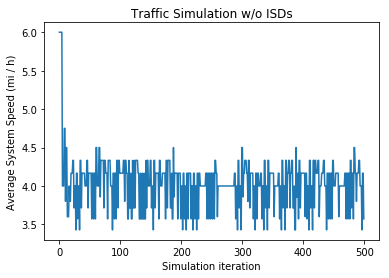

In [5]:
sim = Sim()
for i in range(500):
    sim.step()
sim.data_analysis()
without_isd = sim.avg_speed

In [6]:
class ISD(Car):
    def __init__(self):
        super().__init__('isd')
    
    def set_state(self, sys_speed, isd_speed, car_type, car_speed):
        self.state = [sys_speed, isd_speed, car_type, car_speed]
        
    def decr_speed(self):
        if self.speed > 1:
            self.speed -= 1
    
    def brake(self):
        self.speed = math.floor(self.speed / 2) if math.floor(self.speed / 2) else 1
        
    def select_e_greedily(self, Qmat, e):
        [sys_speed, isd_speed, car_type, car_speed] = self.state
        choices = Qmat[sys_speed - 1][isd_speed - 1][car_type][car_speed - 1]
        
        if np.random.uniform(0, 1) < e:
            return np.random.choice(list(choices.keys()))
        else:
            return max(choices, key = choices.get)

In [7]:
class Simulation:
    CAR_LENGTH           = 6
    ROAD_LENGTH          = CAR_LENGTH * 20
    DESIRED_SPEED        = 6
    
    def __init__(self):
        self.cars        = []
        self.init_cars()
        self.iteration   = 0
        self.avg_speed   = {}
        
    def init_cars(self):
        self.cars.append(self.generate_car())
        
    def generate_car(self):
        speed = 6
        n = rand.randint(0, 3)
        if n == 0:
            car = Truck()
        elif n == 1:
            car = Sedan()
        elif n == 2:
            car = SUV()
        else:
            car = Sport()
        car.set_speed(speed)
        return car
    
    def step(self):
        if self.cars[0].x > self.ROAD_LENGTH:
            self.cars.pop(0)
        
        fender_dist = None
        total_speed = self.cars[0].speed
        
        if self.CAR_LENGTH * 1.25 < self.cars[-1].x:
            self.cars.append(self.generate_car())
            
        self.cars[0].drive()
        self.cars[0].incr_speed()
        
        for i in range(len(self.cars)):
            self.cars[i].drive()
            
            if i != 0:
                fender_dist = self.cars[i - 1].x - self.cars[i].x
                
                self.cars[i].incr_speed()    if fender_dist > self.CAR_LENGTH * 1.25      else None
                self.cars[i].decr_speed()    if fender_dist < self.CAR_LENGTH * 1.25      else None
                self.cars[i].brake()         if fender_dist < self.CAR_LENGTH * 0.625     else None

                total_speed += self.cars[i].speed
                
        self.avg_speed[self.iteration] = total_speed / len(self.cars)
        self.iteration += 1
        
    def data_analysis(self):
        self.avg_speed = sorted(self.avg_speed.items())
        x, y = zip(*self.avg_speed)
        plt.plot(x, y)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation w/o ISDs")
        plt.show()

In [8]:
class RLSimulation(Simulation):
    def __init__(self, alpha, gamma):
        super().__init__()
        
        self.alpha              = alpha
        self.gamma              = gamma
        
        self.n_actions          = 4
        self.n_sys_speed        = 8
        self.n_isd_speed        = 7
        self.n_car_type         = 4
        self.n_car_speed        = 8
        self.Qmat               = [[[[{0: 0., 1: 0., 2: 0. , 3: 0.}
                                     for _ in range(self.n_car_speed)]
                                    for _ in range(self.n_car_type)]
                                   for _ in range(self.n_isd_speed)]
                                  for _ in range(self.n_sys_speed)]
        
        self.speed_incr_reward =  50
        self.speed_same_reward =  10
        self.speed_decr_reward = -20
        self.default_reward    = -1
        
        self.isd_present       = False
        self.isd               = self.generate_isd()
        self.isd.set_state(None, None, None, None)
        
        self.curr_speed        = 0
        
    def generate_isd(self):
        car = ISD()
        car.set_speed(6)
        return car
    
    def setup_training(self):
        self.train_isd         = self.generate_isd()
        self.train_isd.set_state(None, None, None, None)
        self.train_isd_present = False
        self.train_isd_index   = -1
        self.train_cars        = []
        self.train_iteration   = 0
        self.train_avg_speed   = {}
        self.train_cars.append(self.generate_car())
        self.train_car_behind  = False
        
    def train(self, e = 0.1):
        self.train_pop()
                
        fender_dist = None
        total_speed = self.train_cars[0].speed
        
        self.train_add_car()
           
        if self.train_car_behind:
            action = self.train_each_action(e) 
        
        for i in range(len(self.train_cars)):
            self.train_cars[i].drive()
            
            if i != 0:
                fender_dist = self.train_cars[i - 1].x - self.train_cars[i].x
                if self.train_cars[i].car_type != 'isd' or self.train_car_behind == False:
                    self.train_cars[i].incr_speed()    if fender_dist > self.CAR_LENGTH * 1.25      else None
                    self.train_cars[i].decr_speed()    if fender_dist < self.CAR_LENGTH * 1.25      else None
                    self.train_cars[i].brake()         if fender_dist < self.CAR_LENGTH * 0.625     else None
                else:
                    if action == 0:
                        self.train_cars[i].incr_speed()
                    elif action == 1:
                        self.train_cars[i].decr_speed()
                    elif action == 2:
                        self.train_cars[i].brake() 
                    else:
                        None
                    
                total_speed += self.train_cars[i].speed
            
        self.train_avg_speed[self.train_iteration] = total_speed / len(self.train_cars)
        self.curr_speed = int(self.train_avg_speed[self.train_iteration])
        self.train_iteration += 1
           
    def train_pop(self):
         if self.train_cars[0].x > self.ROAD_LENGTH:
            if self.train_cars[0].car_type == 'isd':
                self.train_isd_present = False
                self.train_isd_index   = -1
                self.train_car_behind  = False
                self.train_isd = self.generate_isd()
                self.train_isd.set_state(None, None, None, None)
            
            self.train_cars.pop(0)
            
            if self.train_isd_present == True:
                self.train_isd_index -= 1
                
    def train_add_car(self):
        if self.CAR_LENGTH * 1.25 < self.train_cars[-1].x:
            if self.train_iteration > 0 and self.curr_speed  < 6 and self.train_isd_present == False:
                self.train_cars.append(self.train_isd)
                self.train_isd_present = True
                self.train_isd_index   = len(self.train_cars) - 1
                
            else: 
                self.train_cars.append(self.generate_car())
                if self.train_isd_present:
                    car_behind = self.train_cars[self.train_isd_index + 1]
                    car_type   = self.type_to_num(car_behind.car_type)
                    car_speed  = car_behind.speed
                    self.train_isd.set_state(self.curr_speed, self.train_isd.speed, car_type, car_speed)
                    self.train_car_behind = True
                    
    def train_each_action(self, e):
        [curr_sys_speed, curr_speed, curr_car_type, curr_car_speed] = self.train_isd.state
        car_type = self.type_to_num(curr_car_type)
        for i in range(self.n_actions):
            train_copy = copy.deepcopy(self.train_isd)
            train_cars_copy = self.train_cars.copy()
            outcome = self.train_next_step(train_copy, self.train_isd_index, train_cars_copy, i)
            reward = self.check_reward(curr_sys_speed, outcome[0])
            action = train_copy.select_e_greedily(self.Qmat, e = e)
            
            self.Qmat[curr_sys_speed - 1][curr_speed - 1][car_type][curr_car_speed - 1][i] += self.alpha *\
                (reward + self.gamma * self.Qmat[int(outcome[0]) - 1][outcome[1] - 1][car_type][outcome[2] - 1][action] -
                 self.Qmat[curr_sys_speed - 1][curr_speed - 1][car_type][curr_car_speed - 1][i])
            
    def train_next_step(self, isd, isd_index, cars, action):
        fender_dist = None
        total_speed = cars[0].speed
        
        if self.CAR_LENGTH * 1.25 < cars[-1].x:
            cars.append(self.generate_car())
            
        cars[0].drive()
        cars[0].incr_speed()
        
        for i in range(len(cars)):
            cars[i].drive()
            
            if i != 0: 
                fender_dist = cars[i - 1].x - cars[i].x
                
                if cars[i].car_type != 'isd':
                    cars[i].incr_speed()    if fender_dist > self.CAR_LENGTH * 3      else None
                    cars[i].decr_speed()    if fender_dist < self.CAR_LENGTH * 3      else None
                    cars[i].brake()         if fender_dist < self.CAR_LENGTH * 1.5    else None
                else:
                    if action == 0:
                        cars[i].incr_speed()
                    elif action == 1:
                        cars[i].decr_speed()
                    elif action == 2:
                        cars[i].brake()
                    else:
                        None
            total_speed += cars[i].speed
            
        sys_avg = total_speed / len(cars)
        isd_speed = cars[isd_index].speed
        car_speed = cars[isd_index + 1].speed
        return sys_avg, isd_speed, car_speed
    
    def check_reward(self, init_speed, curr_speed):
        if curr_speed > init_speed:
            return self.speed_incr_reward
        elif curr_speed < init_speed:
            return self.speed_decr_reward
        elif abs(curr_speed - init_speed) <= 0.0001:
            return self.speed_same_reward
        else:
            return self.default_reward
        
    def training_data_analysis(self):
        self.train_avg_speed = sorted(self.train_avg_speed.items())
        x, y = zip(*self.train_avg_speed)
        plt.plot(x, y)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation Training w/ ISDs")
        plt.show()
        
    def type_to_num(self, car_type):
        if car_type == 'truck':
            return 0
        elif car_type == 'sedan':
            return 1
        elif car_type == 'suv':
            return 2
        else:
            return 3
        
    def setup_step(self):
        self.isd               = self.generate_isd()
        self.isd.set_state(None, None, None, None)
        self.isd_present       = False
        self.isd_index         = -1
        self.cars              = []
        self.iteration         = 0
        self.avg_speed         = {}
        self.cars.append(self.generate_car())
        self.car_behind        = False
        self.curr_speed        = 0
        
    def step_when_slow(self):
        if self.cars[0].x > self.ROAD_LENGTH:
            if self.cars[0].car_type == 'isd':
                self.isd_present = False
                self.isd_index   = -1
                self.car_behind  = False
                self.isd = self.generate_isd()
                self.isd.set_state(None, None, None, None)
            
            self.cars.pop(0)
            
            if self.isd_present == True:
                self.isd_index -= 1
        
        fender_dist = None
        total_speed = self.cars[0].speed
        
        if self.CAR_LENGTH * 1.25 < self.cars[-1].x:
            if self.iteration > 0 and self.curr_speed  < 6 and self.isd_present == False:
                self.cars.append(self.isd)
                self.isd_present = True
                self.isd_index   = len(self.cars) - 1
                
            else: 
                self.cars.append(self.generate_car())
                if self.isd_present:
                    car_behind_isd = self.cars[self.isd_index + 1]
                    car_type   = self.type_to_num(car_behind_isd.car_type)
                    car_speed  = car_behind_isd.speed
                    self.isd.set_state(self.curr_speed, self.isd.speed, car_type, car_speed)
                    self.car_behind = True
            
        self.cars[0].drive()
        self.cars[0].incr_speed()
        
        if self.car_behind:
            action = self.isd.select_e_greedily(self.Qmat, e = 0.)
            
        for i in range(len(self.cars)):
            self.cars[i].drive()
            
            if i != 0:
                fender_dist = self.cars[i - 1].x - self.cars[i].x
                
                if self.cars[i].car_type != 'isd' or self.car_behind == False:
                    self.cars[i].incr_speed()    if fender_dist > self.CAR_LENGTH * 1.25      else None
                    self.cars[i].decr_speed()    if fender_dist < self.CAR_LENGTH * 1.25      else None
                    self.cars[i].brake()         if fender_dist < self.CAR_LENGTH * 0.625     else None
                else:
                    if action == 0:
                        self.cars[i].incr_speed()
                    elif action == 1:
                        self.cars[i].decr_speed()
                    elif action == 2:
                        self.cars[i].brake()
                    else:
                        None

                total_speed += self.cars[i].speed
                
        self.avg_speed[self.iteration] = total_speed / len(self.cars)
        self.iteration += 1
        
    def step(self):
        if self.cars[0].x > self.ROAD_LENGTH:
            self.cars.pop(0)
        
        fender_dist = None
        total_speed = self.cars[0].speed
        
        if self.CAR_LENGTH * 1.25 < self.cars[-1].x:
            self.cars.append(self.step_generate_car())
            
        self.cars[0].drive()
        self.cars[0].incr_speed()
        
        for i in range(len(self.cars)):
            self.cars[i].drive()
            
            if i != 0:
                fender_dist = self.cars[i - 1].x - self.cars[i].x
                
                self.cars[i].incr_speed()    if fender_dist > self.CAR_LENGTH * 1.25      else None
                self.cars[i].decr_speed()    if fender_dist < self.CAR_LENGTH * 1.25      else None
                self.cars[i].brake()         if fender_dist < self.CAR_LENGTH * 0.625     else None

                total_speed += self.cars[i].speed
                
        self.avg_speed[self.iteration] = total_speed / len(self.cars)
        self.iteration += 1
        
    def step_generate_car(self):
        speed = 6
        n = rand.randint(0, 4)
        if n == 0:
            car = Truck()
        elif n == 1:
            car = Sedan()
        elif n == 2:
            car = SUV()
        elif n == 3:
            car = Sport()
        else:
            car = ISD()
        car.set_speed(speed)
        return car
    
    def data_analysis(self):
        self.avg_speed = sorted(self.avg_speed.items())
        x, y = zip(*self.avg_speed)
        plt.plot(x, y)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation w/ ISDs")
        plt.show()

Episode: 50000


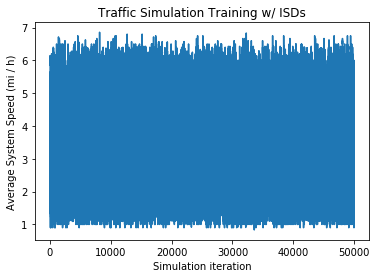

In [9]:
rl = RLSimulation(0.5, 1)

rl.setup_training()
for i in range(0, 50000 + 1):
    if i % 100 == 0:
        clear_output(wait=True)
        print(f"Episode: {i}")
    rl.train()
rl.training_data_analysis()

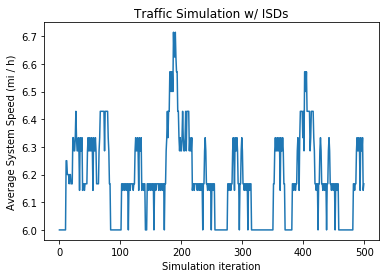

In [10]:
rl.setup_step()
for i in range(500):
    rl.step_when_slow()
rl.data_analysis()
rl_when_slow = rl.avg_speed

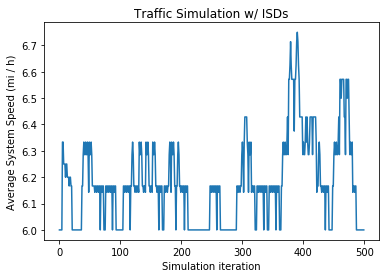

In [11]:
rl.setup_step()
for i in range(500):
    rl.step()
rl.data_analysis()
rl_randomly = rl.avg_speed

In [12]:
class Data_Analysis:
    def __init__(self, dataset_1, dataset_2, dataset_3):
        self.dataset_1 = dataset_1
        self.dataset_2 = dataset_2
        self.dataset_3 = dataset_3
        
    def graph_dataset_1(self):
        x, y = zip(*self.dataset_1)
        plt.plot(x, y)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation w/o ISDs")
        plt.show()
        
    def graph_dataset_2(self):
        x, y = zip(*self.dataset_2)
        plt.plot(x, y)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation w/ ISDs")
        plt.show()
        
    def graph_compare_datasets(self):
        x, y1 = zip(*self.dataset_1)
        x, y2 = zip(*self.dataset_2)
        x, y3 = zip(*self.dataset_3)
        plt.plot(x, y1)
        plt.plot(x, y2)
        plt.plot(x, y3)
        plt.xlabel("Simulation iteration")
        plt.ylabel("Average System Speed (mi / h)")
        plt.title("Traffic Simulation Average Speed Comparison")
        plt.legend(['W/O ISDs', 'W/ ISDs when slow', 'W/ ISDs randomly'], loc='lower left')
        plt.show()
    
    def compare_datasets_avg(self):
        self.avg_dataset_1 = 0
        for i in range(len(self.dataset_1)):
            self.avg_dataset_1 += self.dataset_1[i][1]
        self.avg_dataset_1 /= len(self.dataset_1)
        
        self.avg_dataset_2 = 0
        for i in range(len(self.dataset_2)):
            self.avg_dataset_2 += self.dataset_2[i][1]
        self.avg_dataset_2 /= len(self.dataset_2)
        
        self.avg_dataset_3 = 0
        for i in range(len(self.dataset_3)):
            self.avg_dataset_3 += self.dataset_3[i][1]
        self.avg_dataset_3 /= len(self.dataset_3)
        
        print(f"No ISD vs. ISD when slow: " + str(self.avg_dataset_2 - self.avg_dataset_1))
        print(f"No ISD vs. ISD randomly: " + str(self.avg_dataset_3 - self.avg_dataset_1))
        
    def graph_compare_datasets_avg(self):
        sims = ('No ISDs', 'ISDs when slow', 'ISDs randomly')
        avgs = (self.avg_dataset_1, self.avg_dataset_2, self.avg_dataset_3)
        x_axis = np.arange(len(sims))
        y_axis = np.arange(len(avgs))
        plt.bar(x_axis, y_axis, align='center')
        plt.xticks(x_axis, sims)
        plt.yticks(y_axis, avgs)
        plt.xlabel('Traffic Simulation Type')
        plt.ylabel('Average System Speed (mi/h)')
        plt.title('Traffic Simulation Average Speed Comparison')
        plt.show()
        
    def calc_std_dev(self):
        data_1 = []
        data_2 = []
        data_3 = []
        for i in range(len(self.dataset_1)):
            data_1.append(self.dataset_1[i][1])
        for i in range(len(self.dataset_2)):
            data_2.append(self.dataset_2[i][1])
        for i in range(len(self.dataset_3)):
            data_3.append(self.dataset_3[i][1])
        self.std_dev_1 = np.std(data_1)
        self.std_dev_2 = np.std(data_2)
        self.std_dev_3 = np.std(data_3)
        return self.std_dev_1, self.std_dev_2, self.std_dev_3
    
    def graph_std_dev(self):
        
        sims = ('No ISDs', 'ISDs when slow', 'ISDs randomly')
        devs = (self.std_dev_1, self.std_dev_2, self.std_dev_3)
        x_axis = np.arange(len(sims))
        y_axis = np.arange(len(devs))
        plt.bar(x_axis, y_axis, align='center')
        plt.xticks(x_axis, sims)
        plt.yticks(y_axis, devs)
        plt.xlabel('Traffic Simulation Type')
        plt.ylabel('Standard Deviation')
        plt.title('Traffic Simulation Standard Deviation Comparison')
        plt.show()
        
    def get_datasets_avg(self):
        return self.avg_dataset_1, self.avg_dataset_2, self.avg_dataset_3

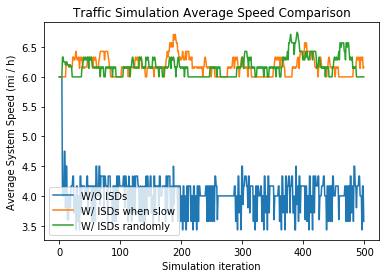

No ISD vs. ISD when slow: 2.1351214285714217
No ISD vs. ISD randomly: 2.131807142857136


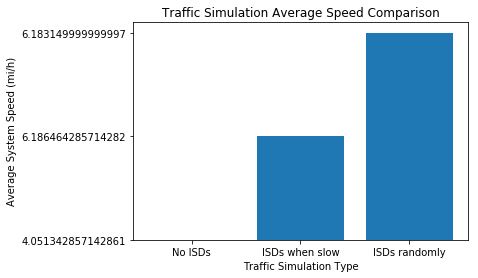

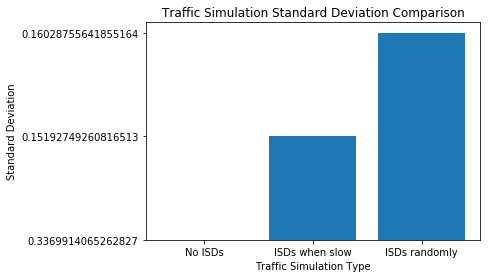

In [13]:
analysis = Data_Analysis(without_isd, rl_when_slow, rl_randomly)
analysis.graph_compare_datasets()
analysis.compare_datasets_avg()
analysis.graph_compare_datasets_avg()
analysis.calc_std_dev()
analysis.graph_std_dev()